# Interpretability across datasets

In [1]:
import os
from pathlib import Path
from typing import List
import warnings
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joypy

import tqdm

import torch
from torch import nn
from torch.utils.data import DataLoader
from captum.attr import IntegratedGradients, DeepLift

import logomaker

import NegativeClassOptimization.config as config
import NegativeClassOptimization.utils as utils
import NegativeClassOptimization.preprocessing as preprocessing
from NegativeClassOptimization import ml
from NegativeClassOptimization import datasets, pipelines, visualisations

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [2]:
# Given a task specification, fetch experiment_id and run_id

# Binders
task1 = {
    "ag_pos": "1ADQ_high",
    "ag_neg": "1ADQ_looser",  # or "1ADQ_95low"
}

# 1v1
task2 = {
    "ag_pos": "1ADQ",
    "ag_neg": "3VRL",
}

# 1v2
task3 = {
    "ag_pos": "1ADQ",
    "ag_neg": ("3VRL", "5E94"),
}

# 1v9
task4 = {
    "ag_pos": "1ADQ",
    "ag_neg": "9",
}

api = utils.MLFlowTaskAPI()
api.get_experiment_and_run(task1), api.get_experiment_and_run(task2), api.get_experiment_and_run(task3), api.get_experiment_and_run(task4)

(('14', '23288c5593a34e958091e1bd5206b3b9'),
 ('11', 'eb7a70a5cbdb45f48097d3cf9f179f87'),
 ('12', '274451d49f144394813038d173d7ce35'),
 ('13', 'd303d2c7671a42248306064b408d0901'))

In [3]:
task = task4

experiment_id, run_id = api.get_experiment_and_run(task)
artifacts_path = Path(f"../data/nco_mlflow_runs/ftp/artifacts_store/{experiment_id}/{run_id}/artifacts/")

# This is a hack to correct for a bug in folder/file naming
dataset_hash = list((artifacts_path / "dataset/train_dataset.tsv").glob("*tsv"))[0].stem.split("_")[0]

df_train_path = artifacts_path / f"dataset/train_dataset.tsv/{dataset_hash}_train_dataset.tsv"
df_test_path = artifacts_path / f"dataset/test_dataset.tsv/{dataset_hash}_test_dataset.tsv"
model_path = artifacts_path / f"models/trained_model"

In [4]:
ag_pos = task["ag_pos"]
ag_neg = task["ag_neg"]

df_para = utils.load_paratopes()
df_train = pd.read_csv(df_train_path, sep="\t")
df_test = pd.read_csv(df_test_path, sep="\t")
model = torch.load(Path(model_path) / "data/model.pth")

attributors = [
    ml.Attributor(model,
        type="deep_lift", 
        baseline_type="shuffle",
        compute_on="logits",
        multiply_by_inputs=True,
    ),
]

In [5]:
df = ml.compute_and_collect_model_predictions_and_attributions(df_train, model, attributors, N=1000)
df.head()

,slide,enc,logits,expits,y_pred,y_true,is_pred_correct,attributions
0,AILIYDYDGRF,"[[tensor(1.), tensor(0.), tensor(0.), tensor(0...",7.351225,0.999359,1,1,True,{'deep_lift__logits__shuffle__multiplyTrue': {...
1,RWDLLLRSNYA,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",6.408793,0.998356,1,1,True,{'deep_lift__logits__shuffle__multiplyTrue': {...
2,RLGLAYYSNLY,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",6.179682,0.997933,1,1,True,{'deep_lift__logits__shuffle__multiplyTrue': {...
3,KLDLYYAMDYW,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",4.912350,0.992698,1,1,True,{'deep_lift__logits__shuffle__multiplyTrue': {...
4,AIDCDWYFDVW,"[[tensor(1.), tensor(0.), tensor(0.), tensor(0...",4.802368,0.991857,1,1,True,{'deep_lift__logits__shuffle__multiplyTrue': {...


In [6]:
df_sel = ml.get_df_sel(attributors[0].name, df, df_para, ag_pos, ag_neg)
print(df_sel.shape)
df_sel.head()

(1000, 15)


,slide,enc,logits,expits,y_pred,y_true,is_pred_correct,attributions,baseline,Antigen,Slide,Label,hotspot_ID,agregatesAGEpitope,agregatesABParatope
0,AILIYDYDGRF,"[[tensor(1.), tensor(0.), tensor(0.), tensor(0...",7.351225,0.999359,1,1,True,"[[tensor(0.3557, grad_fn=<UnbindBackward0>), t...",shuffle,1ADQ,AILIYDYDGRF,1ADQ_A,1ADQ_A_H1,L1--R1--P1--W1--V1D2--V1Q1V1--A1K1--T1V1L1H1Q3...,A2I3L4I3Y1D1Y1D1G2R1F4*
1,RWDLLLRSNYA,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",6.408793,0.998356,1,1,True,"[[tensor(0., grad_fn=<UnbindBackward0>), tenso...",shuffle,1ADQ,RWDLLLRSNYA,1ADQ_A,1ADQ_A_H2,P1--V1F1--V3--D3V1S1Q2--Q1V1--T1K1P1--E1--Y1R2...,R1W4D1L4L3L3R1S2--Y3A2*
2,RLGLAYYSNLY,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",6.179682,0.997933,1,1,True,"[[tensor(0., grad_fn=<UnbindBackward0>), tenso...",shuffle,1ADQ,RLGLAYYSNLY,1ADQ_A,1ADQ_A_H2,P1--V1F1--V3--D3V1S1Q2--Q1V1--T1K1P1--E1--Y1R2...,R1L4G1L4A3Y3Y1S2--L3Y2*
3,KLDLYYAMDYW,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",4.912350,0.992698,1,1,True,"[[tensor(0.0073, grad_fn=<UnbindBackward0>), t...",shuffle,1ADQ,KLDLYYAMDYW,1ADQ_A,1ADQ_A_H2,P1--V1F1--V3--D3V1S1Q2--Q1V1--T1K1P1--E1--Y1R2...,K1L4D1L4Y3Y3A1M2--Y3W2*
4,AIDCDWYFDVW,"[[tensor(1.), tensor(0.), tensor(0.), tensor(0...",4.802368,0.991857,1,1,True,"[[tensor(-0.2864, grad_fn=<UnbindBackward0>), ...",shuffle,1ADQ,AIDCDWYFDVW,1ADQ_A,1ADQ_A_H2,P1--V1F1--V3--D3V1S1Q2--Q1V1--T1K1P1--E1--Y1R2...,A2I3--C2D1W3Y1F4D1V4W3*


In [7]:
paratope_ranks, _ = ml.get_paratope_ranks(1, df_sel)
random_ranks, _ = ml.get_paratope_ranks(1, df_sel, True)
print(len(paratope_ranks))

104


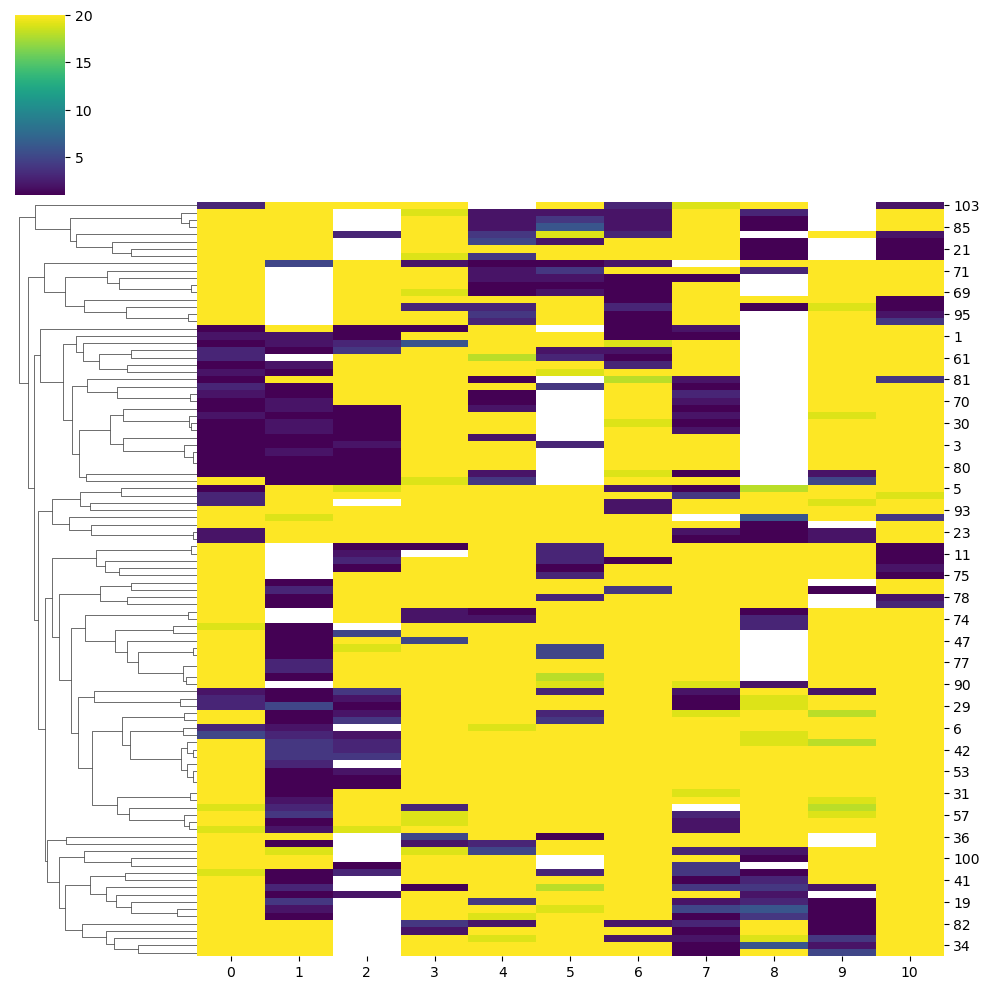

In [11]:
df_paratope_ranks = pd.DataFrame(paratope_ranks.values())
df_random_ranks = pd.DataFrame(random_ranks.values())

g = sns.clustermap(
    df_paratope_ranks, 
    row_cluster=True,
    col_cluster=False, 
    cmap="viridis",
    # center=1,
    mask=(df_paratope_ranks.values == 0),
    )

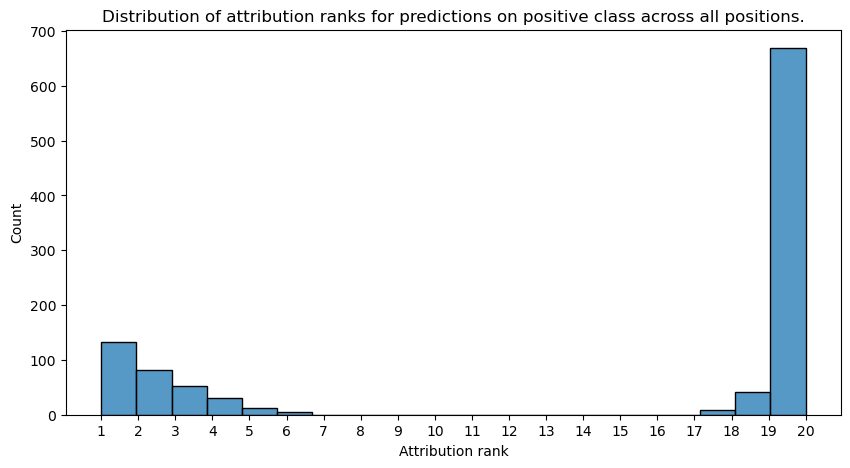

In [10]:
def plot_attr_ranks_dist(df_paratope_ranks):
    fig, ax = plt.subplots(figsize=(10, 5))
    hist_vals = df_paratope_ranks.values.reshape(-1)
    sns.histplot(hist_vals[hist_vals > 0], bins=20, ax=ax)
    ax.set_title("Distribution of attribution ranks for predictions on positive class across all positions.")
    ax.set_xticks(np.arange(1, 21, 1))
    ax.set_xlabel("Attribution rank")

plot_attr_ranks_dist(df_paratope_ranks)

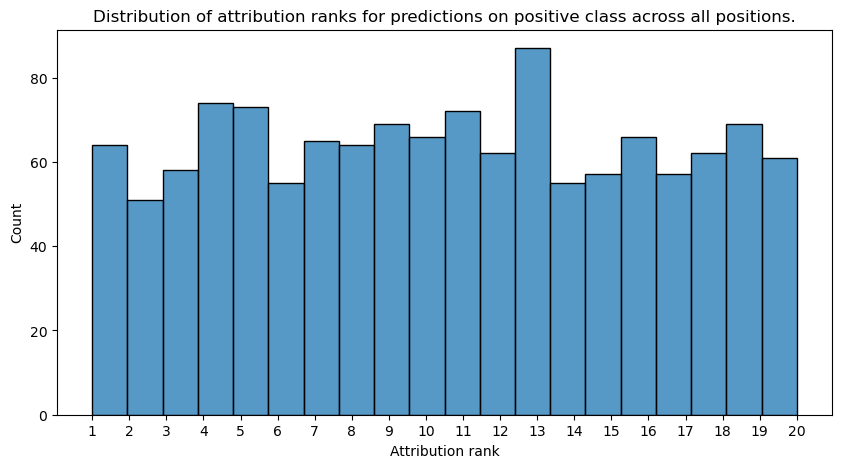

In [12]:
def plot_attr_ranks_dist(df_paratope_ranks):
    fig, ax = plt.subplots(figsize=(10, 5))
    hist_vals = df_paratope_ranks.values.reshape(-1)
    sns.histplot(hist_vals[hist_vals > 0], bins=20, ax=ax)
    ax.set_title("Distribution of attribution ranks for predictions on positive class across all positions.")
    ax.set_xticks(np.arange(1, 21, 1))
    ax.set_xlabel("Attribution rank")

plot_attr_ranks_dist(df_random_ranks)